### Importing Libraries

In [ ]:
# !uv pip install radon numpy pandas tqdm nltk transformers

In [32]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("PyTorch version:", torch.__version__)
if device.type == 'cuda':
    print("CUDA version:", torch.version.cuda)
    print("Device name:", torch.cuda.get_device_name(0))

def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

Using device: cuda
PyTorch version: 2.8.0+cu129
CUDA version: 12.9
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [33]:
import subprocess
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore', category=SyntaxWarning)

from radon.raw import analyze as radon_analyze
from radon.complexity import cc_visit
from radon.metrics import mi_visit, h_visit

dataset_file = "lab2_diffs.csv"
output_folder = "results"
os.makedirs(output_folder, exist_ok=True)

In [38]:
df = pd.read_csv(dataset_file)
display(df.head(20))

,Hash,Message,File Name,File Path,Change Type,Source Code (before),Source Code (current),Diff,LLM Inference (fix type),Rectified Message
0,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,constants.py,constants.py,ModificationType.MODIFY,import os\nimport numpy as np\n\n\nGENERALLY_B...,import os\nimport numpy as np\n\nPRODUCTION_QU...,"@@ -1,9 +1,6 @@\n import os\n import numpy as ...",add missing constants,[constants.py]: Fix default point thickness to...
1,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,displayer.py,displayer.py,ModificationType.MODIFY,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -55,7 +55,7 @@ def paint_mobjects(mobjects,...",add nudge to displayer.py,[displayer.py]: Fix potential offset issue in ...
2,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,mobject.py,mobject\mobject.py,ModificationType.MODIFY,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -21,7 +21,7 @@ class Mobject(object):\n ...",add missing docstring,[mobject.py]: Fix inconsistent point_thickness...
3,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",__init__.py,__init__.py,ModificationType.MODIFY,from animation import *\nfrom mobject import *...,from animation import *\nfrom scene import *\n...,"@@ -1,10 +1,13 @@\n from animation import *\n-...",add missing import statements,[__init__.py]: Fix [bug/issue/etc] in [functio...
4,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",__init__.py,animation\__init__.py,ModificationType.MODIFY,from animation import *\nfrom transform import...,from animation import *\nfrom meta_animations ...,"@@ -1,3 +1,4 @@\n from animation import *\n-fr...",add missing newline,Fix regression in transform module by adding m...
5,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",animation.py,animation\animation.py,ModificationType.MODIFY,from PIL import Image\nfrom colour import Colo...,from PIL import Image\nfrom colour import Colo...,"@@ -7,11 +7,10 @@ import os\n import copy\n im...",add missing config to missing color animation,[animation.py]: Fix bug in writeGif function b...
6,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",meta_animations.py,animation\meta_animations.py,ModificationType.ADD,NaN,import numpy as np\nimport itertools as it\nfr...,"@@ -0,0 +1,95 @@\n+import numpy as np\n+import...",add tests for animation.update and animation.u...,[meta_animations.py]: Fix bug in DelayByOrder ...
7,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",simple_animations.py,animation\simple_animations.py,ModificationType.MODIFY,import numpy as np\nimport itertools as it\nfr...,import numpy as np\nimport itertools as it\nfr...,"@@ -2,42 +2,12 @@ import numpy as np\n import ...",add some more classes to the animation class,[simple_animations.py]: Refactor commit messag...
8,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",transform.py,animation\transform.py,ModificationType.MODIFY,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -4,39 +4,12 @@ import inspect\n import copy...",add new animation classes,[transform.py]: Fix broken behavior in path_al...
9,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",displayer.py,displayer.py,ModificationType.MODIFY,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -8,8 +8,7 @@ import cv2\n from colour impor...",add more examples to the nightly modified file,[displayer.py]: Fix compression issue in write...


In [39]:
# check for nan values in the df
print("Checking for NaN values in each column:")
print(df.isna().sum())

Checking for NaN values in each column:
Hash                         0
Message                      0
File Name                    0
File Path                    0
Change Type                  0
Source Code (before)        52
Source Code (current)       35
Diff                         0
LLM Inference (fix type)     0
Rectified Message            0
dtype: int64


## Baseline Statistics

In [20]:
total_commits = df['Hash'].nunique()        # total number of unique commits
total_files = df.shape[0]                   # total number files
avg_files_per_commit = total_files / total_commits      # average number of files per commit
# avg_files_per_commit_pd = df.groupby('Hash').size().mean()

# Distribution of fix types
fix_type_distribution = df["LLM Inference (fix type)"].value_counts(dropna=False)

# Most frequently modified filenames and extensions
most_modified_filenames = df['File Name'].value_counts()
df['file_extension'] = df['File Name'].apply(
    lambda x: '.' + x.split('.')[-1] if pd.notna(x) and '.' in x else 'no_extension'
)
file_extension_distribution = df['file_extension'].value_counts()



print(f"Total number of unique commits: {total_commits}")
print(f"Total number of files: {total_files}")
print(f"Average number of modified files per commit (manual calc): {avg_files_per_commit:.2f}")
# print(f"Average number of modified files per commit (pandas calc): {avg_files_per_commit_pd:.2f}")
print("\nDistribution of fix types:")
print(fix_type_distribution.head(10))
print("\nMost frequently modified filenames:")
print(most_modified_filenames.head(10))
print("\nDistribution of file extensions:")
print(file_extension_distribution.head(10))

Total number of unique commits: 1121
Total number of files: 2041
Average number of modified files per commit (manual calc): 1.82

Distribution of fix types:
LLM Inference (fix type)
add missing docstring           161
add missing import               95
add missing imports              39
add missing docstrings           29
add missing class attributes     28
add missing comments             27
add missing comment              18
add missing config file          17
update camera.py                 15
add missing config               13
Name: count, dtype: int64

Most frequently modified filenames:
File Name
vectorized_mobject.py    120
mobject.py               113
scene.py                  87
geometry.py               83
camera.py                 60
svg_mobject.py            56
tex_mobject.py            47
config.py                 44
constants.py              36
coordinate_systems.py     36
Name: count, dtype: int64

Distribution of file extensions:
file_extension
.py           1809
.

## Structural Metrics with **radon**:

In [ ]:
def compute_radon_metrics(code):
    """Compute radon metrics: MI, CC, LOC for given source code."""
    if not isinstance(code, str) or code.strip() == "":
        return (np.nan, np.nan, np.nan)

    try:
        # Maintainability Index
        mi = float(mi_visit(code, multi=True))
    except Exception as e:
        mi = np.nan

    try:
        # Cyclomatic Complexity
        cc_results = cc_visit(code)
        cc = np.mean([block.complexity for block in cc_results]) if cc_results else 0.0
    except Exception as e:
        cc = np.nan

    try:
        # Lines of Code
        loc = radon_analyze(code).loc
    except Exception as e:
        loc = np.nan

    return (mi, cc, loc)


# Compute radon metrics for each file before and after the commit
df[['MI_Before', 'CC_Before', 'LOC_Before']] = df['Source Code (before)'].progress_apply(
    lambda x: pd.Series(compute_radon_metrics(x))
)
df[['MI_After', 'CC_After', 'LOC_After']] = df['Source Code (current)'].progress_apply(
    lambda x: pd.Series(compute_radon_metrics(x))
)

# Compute changes in metrics
df['MI_Change'] = df['MI_After'] - df['MI_Before']
df['CC_Change'] = df['CC_After'] - df['CC_Before']
df['LOC_Change'] = df['LOC_After'] - df['LOC_Before']


df.to_csv(f"{output_folder}/structural_metrics.csv", index=False)

In [ ]:
df = pd.read_csv(f"{output_folder}/structural_metrics.csv")
display(df[['Message', 'File Name', 
            'MI_Before', 'MI_After', 'MI_Change', 
            'CC_Before', 'CC_After', 'CC_Change', 
            'LOC_Before', 'LOC_After', 'LOC_Change']
            ].head(20))

,Hash,Message,MI_Before,MI_After,MI_Change,CC_Before,CC_After,CC_Change,LOC_Before,LOC_After,LOC_Change
0,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,56.611516,56.611516,0.000000,0.000000,0.000000,0.0,104.0,103.0,-1.0
1,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,NaN,NaN,NaN,NaN,NaN,NaN,230.0,238.0,8.0
2,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,NaN,NaN,NaN,NaN,NaN,NaN,455.0,455.0,0.0
3,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",100.000000,100.000000,0.000000,0.000000,0.000000,0.0,10.0,13.0,3.0
4,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",100.000000,100.000000,0.000000,0.000000,0.000000,0.0,3.0,4.0,1.0
5,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",58.276524,58.495906,0.219382,1.714286,1.714286,0.0,122.0,120.0,-2.0
6,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",NaN,58.959139,NaN,NaN,3.100000,NaN,NaN,95.0,NaN
7,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",NaN,59.449158,NaN,NaN,2.176471,NaN,233.0,102.0,-131.0
8,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",NaN,51.775973,NaN,NaN,1.961538,NaN,235.0,171.0,-64.0
9,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",NaN,NaN,NaN,NaN,NaN,NaN,198.0,184.0,-14.0


In [ ]:
# ### (d) Change Magnitude Metrics:
# - Compute Semantic Similarity between Source Code (before) and Source Code (current) using CodeBERT.  
# - Compute Token Similarity using BLEU.  
# - Add **Semantic_Similarity** and **Token_Similarity** columns.

import math
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import nltk

nltk.download("punkt")
nltk.download("punkt_tab")

# Load CodeBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
model.eval()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shardul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [43]:
def safe_str(s):
    if s is None:
        return ""
    if isinstance(s, float) and math.isnan(s):
        return ""
    return str(s)

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def compute_codebert_embedding(code):
    """Compute CodeBERT embedding for given source code."""
    if not isinstance(code, str) or code.strip() == "":
        return np.zeros((768,))  # Return zero vector for empty code

    inputs = tokenizer(code, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    # embeddings = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    embeddings = mean_pooling(outputs, inputs['attention_mask']).squeeze().cpu().numpy()
    return embeddings

def compute_semantic_similarity(row):
    """Compute semantic similarity between before and after code using CodeBERT embeddings."""
    before_code = safe_str(row['Source Code (before)'])
    after_code = safe_str(row['Source Code (current)'])

    before_embedding = compute_codebert_embedding(before_code)
    after_embedding = compute_codebert_embedding(after_code)

    if np.linalg.norm(before_embedding) == 0 or np.linalg.norm(after_embedding) == 0:
        return np.nan  # Return NaN if either embedding is zero vector

    similarity = cosine_similarity([before_embedding], [after_embedding])[0][0]
    return similarity

def compute_token_similarity(row):
    """Compute token similarity between before and after code using BLEU score."""
    before_code = safe_str(row['Source Code (before)'])
    after_code = safe_str(row['Source Code (current)'])

    if not before_code or not after_code:
        return np.nan  # Return NaN if either code is empty

    before_tokens = nltk.word_tokenize(before_code)
    after_tokens = nltk.word_tokenize(after_code)

    if len(before_tokens) == 0 or len(after_tokens) == 0:
        return np.nan  # Return NaN if tokenization results in empty lists

    smooth = nltk.translate.bleu_score.SmoothingFunction()
    bleu_score = nltk.translate.bleu_score.sentence_bleu([before_tokens], after_tokens, smoothing_function=smooth.method1)
    return bleu_score

In [ ]:
df['Semantic_Similarity'] = df.progress_apply(compute_semantic_similarity, axis=1)
df['Token_Similarity'] = df.progress_apply(compute_token_similarity, axis=1)

df.to_csv(f"{output_folder}/change_magnitude_metrics.csv", index=False)

100%|██████████| 2041/2041 [02:04<00:00, 16.33it/s]


In [48]:
df = pd.read_csv(f"{output_folder}/change_magnitude_metrics.csv")
display(df[['Message', 'File Name', 'Semantic_Similarity', 'Token_Similarity']].head(20))

,Message,File Name,Semantic_Similarity,Token_Similarity
0,A few fixes to initial point_thickness impleme...,constants.py,0.999283,0.986973
1,A few fixes to initial point_thickness impleme...,displayer.py,1.000000,0.952839
2,A few fixes to initial point_thickness impleme...,mobject.py,0.999760,0.998018
3,"middle of massive restructure, everything stil...",__init__.py,0.997906,0.660184
4,"middle of massive restructure, everything stil...",__init__.py,0.996067,0.701206
5,"middle of massive restructure, everything stil...",animation.py,0.999739,0.980059
6,"middle of massive restructure, everything stil...",meta_animations.py,NaN,NaN
7,"middle of massive restructure, everything stil...",simple_animations.py,0.994631,0.252018
8,"middle of massive restructure, everything stil...",transform.py,0.993418,0.636833
9,"middle of massive restructure, everything stil...",displayer.py,0.999916,0.894411


## Classification and Agreement

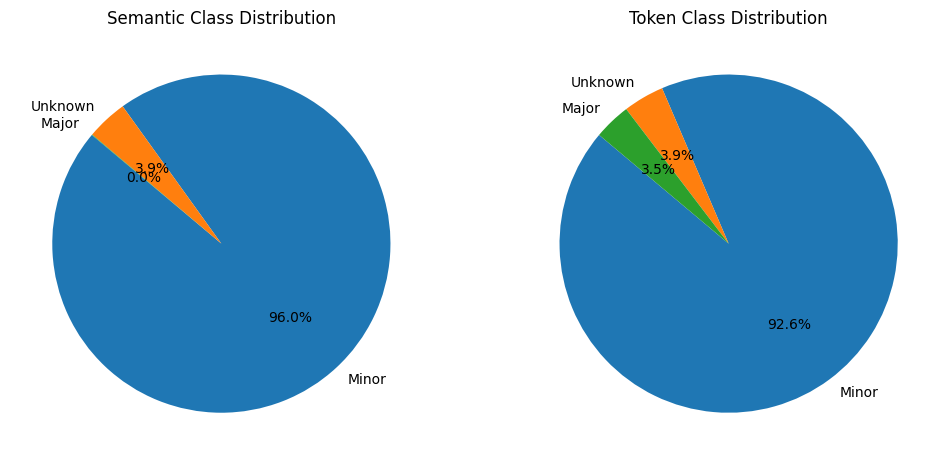

In [66]:
df = pd.read_csv(f"{output_folder}/change_magnitude_metrics.csv")

# taken from lab pdf
SEMANTIC_THRESHOLD = 0.80
TOKEN_THRESHOLD = 0.75

def classify_change(val, threshold):
    # Semantic class
    if not (isinstance(val, float) or isinstance(val, int)) or np.isnan(val):
        return 'Unknown'
    elif val >= threshold:
        return 'Minor'
    else:
        return 'Major'

df['Semantic_Class'] = df['Semantic_Similarity'].apply(lambda x: classify_change(x, SEMANTIC_THRESHOLD))
df['Token_Class'] = df['Token_Similarity'].apply(lambda x: classify_change(x, TOKEN_THRESHOLD))

df.to_csv(f"{output_folder}/final_metrics.csv", index=False)

# pie charts for distribution of Semantic_Class and Token_Class
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
semantic_counts = df['Semantic_Class'].value_counts()
token_counts = df['Token_Class'].value_counts()
axs[0].pie(semantic_counts, labels=semantic_counts.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Semantic Class Distribution')
axs[1].pie(token_counts, labels=token_counts.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Token Class Distribution')
plt.show()


Distribution of agreement between Semantic and Token classifications:
Classes_Agree
YES        1890
Unknown      80
NO           71
Name: count, dtype: int64


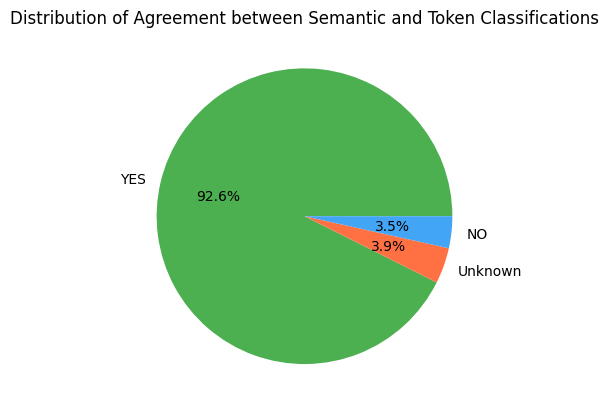

In [67]:
def check_agreement(row):
    if row['Semantic_Class'] == 'Unknown' or row['Token_Class'] == 'Unknown':
        return 'Unknown'
    return 'YES' if row['Semantic_Class'] == row['Token_Class'] else 'NO'
df['Classes_Agree'] = df.apply(check_agreement, axis=1)

df.to_csv(f"{output_folder}/final_metrics.csv", index=False)

# distribution of agreement
agreement_distribution = df['Classes_Agree'].value_counts(dropna=False)
print("\nDistribution of agreement between Semantic and Token classifications:")
print(agreement_distribution)

# pie chart for agreement distribution
import matplotlib.pyplot as plt
labels = agreement_distribution.index.tolist()
sizes = agreement_distribution.values.tolist()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#4CAF50', '#FF7043', '#42A5F5'] )
plt.title("Distribution of Agreement between Semantic and Token Classifications")
plt.show()

In [69]:
df = pd.read_csv(f"{output_folder}/final_metrics.csv")
display(df[['Message', 'File Name',
            'Semantic_Class', 'Token_Class', 'Classes_Agree']
            ].head(20))

,Message,File Name,Semantic_Class,Token_Class,Classes_Agree
0,A few fixes to initial point_thickness impleme...,constants.py,Minor,Minor,YES
1,A few fixes to initial point_thickness impleme...,displayer.py,Minor,Minor,YES
2,A few fixes to initial point_thickness impleme...,mobject.py,Minor,Minor,YES
3,"middle of massive restructure, everything stil...",__init__.py,Minor,Major,NO
4,"middle of massive restructure, everything stil...",__init__.py,Minor,Major,NO
5,"middle of massive restructure, everything stil...",animation.py,Minor,Minor,YES
6,"middle of massive restructure, everything stil...",meta_animations.py,Unknown,Unknown,Unknown
7,"middle of massive restructure, everything stil...",simple_animations.py,Minor,Major,NO
8,"middle of massive restructure, everything stil...",transform.py,Minor,Major,NO
9,"middle of massive restructure, everything stil...",displayer.py,Minor,Minor,YES


## Final Table

In [70]:
df = pd.read_csv(f"{output_folder}/final_metrics.csv")
display(df.head(20))

,Hash,Message,File Name,File Path,Change Type,Source Code (before),Source Code (current),Diff,LLM Inference (fix type),Rectified Message,...,CC_After,LOC_After,MI_Change,CC_Change,LOC_Change,Semantic_Similarity,Token_Similarity,Semantic_Class,Token_Class,Classes_Agree
0,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,constants.py,constants.py,ModificationType.MODIFY,import os\nimport numpy as np\n\n\nGENERALLY_B...,import os\nimport numpy as np\n\nPRODUCTION_QU...,"@@ -1,9 +1,6 @@\n import os\n import numpy as ...",add missing constants,[constants.py]: Fix default point thickness to...,...,0.000000,103.0,0.000000,0.0,-1.0,0.999283,0.986973,Minor,Minor,YES
1,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,displayer.py,displayer.py,ModificationType.MODIFY,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -55,7 +55,7 @@ def paint_mobjects(mobjects,...",add nudge to displayer.py,[displayer.py]: Fix potential offset issue in ...,...,NaN,238.0,NaN,NaN,8.0,1.000000,0.952839,Minor,Minor,YES
2,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,mobject.py,mobject\mobject.py,ModificationType.MODIFY,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -21,7 +21,7 @@ class Mobject(object):\n ...",add missing docstring,[mobject.py]: Fix inconsistent point_thickness...,...,NaN,455.0,NaN,NaN,0.0,0.999760,0.998018,Minor,Minor,YES
3,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",__init__.py,__init__.py,ModificationType.MODIFY,from animation import *\nfrom mobject import *...,from animation import *\nfrom scene import *\n...,"@@ -1,10 +1,13 @@\n from animation import *\n-...",add missing import statements,[__init__.py]: Fix [bug/issue/etc] in [functio...,...,0.000000,13.0,0.000000,0.0,3.0,0.997906,0.660184,Minor,Major,NO
4,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",__init__.py,animation\__init__.py,ModificationType.MODIFY,from animation import *\nfrom transform import...,from animation import *\nfrom meta_animations ...,"@@ -1,3 +1,4 @@\n from animation import *\n-fr...",add missing newline,Fix regression in transform module by adding m...,...,0.000000,4.0,0.000000,0.0,1.0,0.996067,0.701206,Minor,Major,NO
5,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",animation.py,animation\animation.py,ModificationType.MODIFY,from PIL import Image\nfrom colour import Colo...,from PIL import Image\nfrom colour import Colo...,"@@ -7,11 +7,10 @@ import os\n import copy\n im...",add missing config to missing color animation,[animation.py]: Fix bug in writeGif function b...,...,1.714286,120.0,0.219382,0.0,-2.0,0.999739,0.980059,Minor,Minor,YES
6,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",meta_animations.py,animation\meta_animations.py,ModificationType.ADD,NaN,import numpy as np\nimport itertools as it\nfr...,"@@ -0,0 +1,95 @@\n+import numpy as np\n+import...",add tests for animation.update and animation.u...,[meta_animations.py]: Fix bug in DelayByOrder ...,...,3.100000,95.0,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown
7,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",simple_animations.py,animation\simple_animations.py,ModificationType.MODIFY,import numpy as np\nimport itertools as it\nfr...,import numpy as np\nimport itertools as it\nfr...,"@@ -2,42 +2,12 @@ import numpy as np\n import ...",add some more classes to the animation class,[simple_animations.py]: Refactor commit messag...,...,2.176471,102.0,NaN,NaN,-131.0,0.994631,0.252018,Minor,Major,NO
8,2e074afb60d13262ce1e42e83bcf0ed28d95ad82,"middle of massive restructure, everything stil...",transform.py,animation\transform.py,ModificationType.MODIFY,imp